In [2]:
#Download data:
import pandas as pd
all_data = pd.read_csv('MDM_Data_Summary.csv', header=0) 

#Identify headers
headers = all_data.columns
print (headers)

#Temperature data:
Temp = all_data['Sea Temp (F)']
Kelp_Pop =  all_data['Kelp Population']
Urchin_Pop = all_data['Urchin Population']
Otter_Pop = all_data['Otter Population']

Index(['Year', 'Areas (km^2)', 'Otter Population', 'Urchin Population',
       'Urchin Density (per/km^2)', 'Urchins in Otter Area',
       'Urchins to Otter Ratio', 'Kelp Coverage (%)', 'Kelp Coverage (km^2)',
       'Kelp Population', 'Sea Temp (F)'],
      dtype='object')


Optimised Parameters (r, a_uk, m_u, b_uk, a_ou, b_ou, m_o): [8.60336474e-01 7.07873181e-03 1.00000000e-02 3.33457956e-03
 1.00000000e-04 1.02262601e-03 9.44197625e-02]


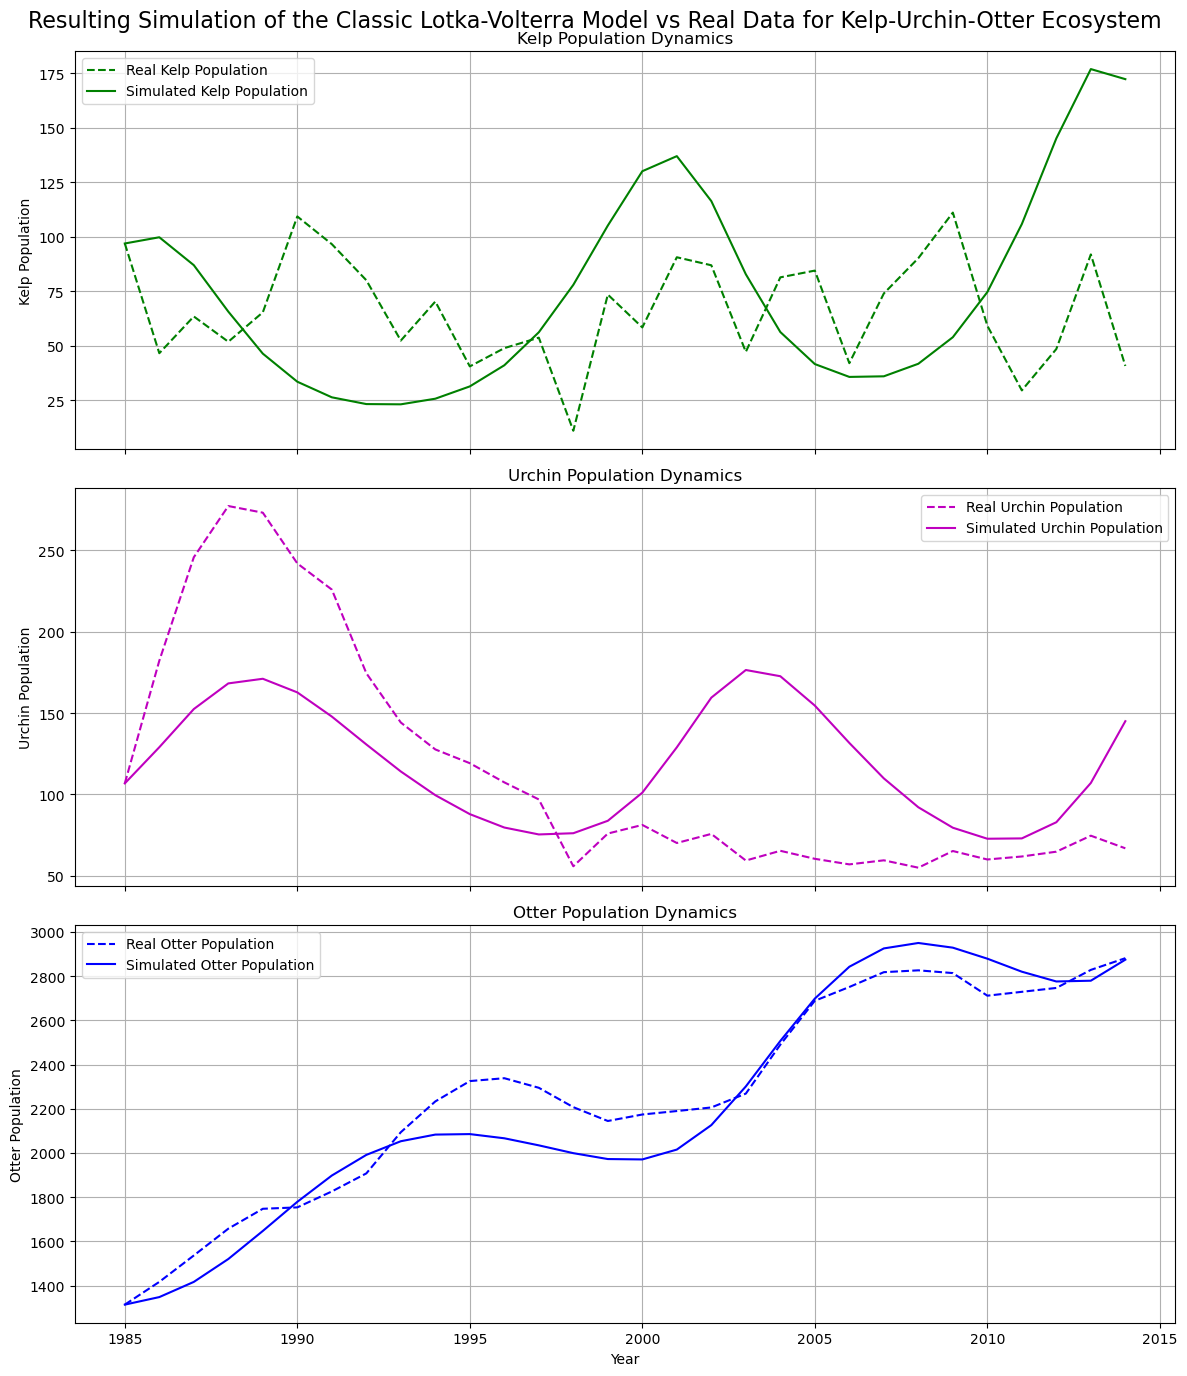

In [18]:
import numpy as np 
import matplotlib.pyplot as plt 
import random 
import math 
import csv
from scipy.integrate import solve_ivp 
from scipy.optimize import curve_fit 
from scipy.optimize import least_squares
import matplotlib.pyplot as plt 

## Approach: define a function for each individual step, then compile together at the end of code under a main function 

def load_data (dataset):
    data = pd.read_csv(dataset) 
    return data

#Normalising Data values
#Encountered issues with trying to plot population as urchin and kelp populaiton numbers are very large -> caused overflow 
#multiplying each species by scaling factor specific to them, and create a seperate dataset containing these vals instead 
def normalise(data):
    scale_kelp = 1e6 
    scale_urchin = 1e6 
    scale_otter = 1
    scale_factors = {'kelp': scale_kelp, 'urchin': scale_urchin, 'otter': scale_otter}
    
    #new scaled data
    normalised_data = data.copy() 
    normalised_data['Kelp Population'] = data['Kelp Population'] / scale_kelp 
    normalised_data['Urchin Population'] = data['Urchin Population'] / scale_urchin 

    return normalised_data, scale_factors 

#define the classic Lotka Volterra Model between Kelp, Urchin and Otters 
def lotka_volterra(t, y, r, a_uk, m_u, b_uk, a_ou, b_ou, m_o):
    K, U, O = y # assign the current population values of the given time step. Expect List/ Numpy array of size 3. y[0]=K, y[1]=U, y[2]=O
                #y value updates as ode integrates over time 
    #The classic Lotka Volterra Model (as described in our ppt) 
    dK_dt = r*K - a_uk*K*U 
    dU_dt = b_uk*K*U - m_u*U - a_ou*U*O
    dO_dt = b_ou*U*O - m_o*O
    return [dK_dt, dU_dt, dO_dt]
    
#simulate the population dynamics using the Lotka Voltera Model, with parameters as inputs 
#Returns the population time series values for each species 
def simulate_population_dynamics(t, r, a_uk, m_u, b_uk, a_ou, b_ou, m_o, K0, U0, O0):
    y0 = [K0, U0, O0] #assign initial Kelp, Urchin and Otter Populations to y0 

    #solve_ivp : numerically integrates system of ODE's given an initial value (in this case the values corresponding to the first year in the dataset 
        #outputs: (t: time points, y: values of solutions at t)
    sol = solve_ivp(
        lotka_volterra,                 # function to be solved - System of equations
        [t[0], t[-1]],                  # Time interval over which integration is done - starts at t=t0 and ends at t=tf 
        y0,                             # Initial population values for Kelp, Urchins and Otters 
        args=(r, a_uk, m_u, b_uk, a_ou, b_ou, m_o),  # Parameters that need to be passed in order to use in the Lotka Volterra function 
        method='BDF',                   # curve_fit and LSODA not good as good fits for population data - BDF: Backwards Differentiation Formula, better for Lotka-Volterra equations
        t_eval=t,                       # Time steps at which to store solutions (each t/ year) 
        atol=1e-8,                      # Absolute tolerance for local error estimated - number of correct decimal places (difference between two numbers)
        rtol=1e-8)                      # Relative tolerance for local error estimates  - number of correct digits (percentage difference) 
    
    simulated_pops = sol.y #extract the 'y' output values from solve_ivp function - the simulated population values 
    simulated_pop = simulated_pops.T  #change for column output 
    return [simulated_pop[:,0], simulated_pop[:,1], simulated_pop[:,2]] #return population values for Kelp, Urchin and Otters by accessing their respective columns

#optimise parameters from simulated models to best fit the given data
def optimise_params(dataset, scaling_factors):
    relative_time = dataset['Year'] - dataset['Year'].min() #convert time column to a relative time column for ease
    t = relative_time.values 
    KelpPop_real = dataset['Kelp Population'].values
    UrchinPop_real = dataset['Urchin Population'].values 
    OtterPop_real = dataset['Otter Population'].values

    #Initial parameter and population input values for the simulation to initate
    initial_parameters = [0.5, 0.002, 0.1, 0.001, 0.002, 0.0005, 0.1] # r, a_uk, m_u, b_uk, a_ou, b_ou, m_o -> guess approximations -> Could find more data driven values instead of guesses?) 
    K0, U0, O0 = KelpPop_real[0], UrchinPop_real[0], OtterPop_real[0]

    #Objective function -> the function which to minimise the difference between the real population data and the predictions of the simulated model to predict to models fit to the real data 
    def objective_function(parameters, t, Kelp_real, Urchin_real, Otter_real):
        r, a_uk, m_u, b_uk, a_ou, b_ou, m_o = parameters
        
        # Simulate population values with current set of parameter values by calling the previously defined simulate_population_dynamics function 
        Kelp_sim, Urchin_sim, Otter_sim = simulate_population_dynamics(t, r, a_uk, m_u, b_uk, a_ou, b_ou, m_o, K0, U0, O0)
            
        # Calculate the error value between simulated population vals and real population vals
        errors_Kelp = Kelp_sim - Kelp_real
        errors_Urchin = Urchin_sim - Urchin_real 
        errors_Otter = Otter_sim - Otter_real
            
        # Return error values (to then be minimised) 
        return np.concatenate([errors_Kelp, errors_Urchin, errors_Otter])    

    # Add bounds for parameter values- keeps values realistic, lower bounds keep parameters from becoming zero or below, upper bounds prevent too large values
    bounds = ([0.01, 0.0001, 0.01, 0.0001, 0.0001, 0.0001, 0.01], 
              [2.0, 0.1, 1.0, 0.1, 0.1, 0.1, 1.0])

    #runs the objectively parameters repeatedly and uses different parameter values for each iteration 
    #adjusts parameters to reduce the errors calculated each time until it reaches the tolerance limits (ftol, xtol) defined
    #least_squares required output: x - the optimisation solution found
    result = least_squares(objective_function, initial_parameters, args=(t, KelpPop_real, UrchinPop_real, OtterPop_real), bounds=bounds, ftol=1e-8, xtol=1e-8) 
    #extract the parameters of the simulation that best fits
    optimised_parameters = result.x 

    return optimised_parameters 

def plot_results (dataset, optimised_parameters, scale_factors):
    relative_time = dataset['Year'] - dataset['Year'].min() 
    t = relative_time.values 

    #real population values
    KelpPop_real = dataset['Kelp Population'].values
    UrchinPop_real = dataset['Urchin Population'].values 
    OtterPop_real = dataset['Otter Population'].values
    
    # Initial values for simulation 
    K0 = KelpPop_real[0]
    U0 = UrchinPop_real[0]
    O0 = OtterPop_real[0]

    Kelp_simulated, Urchin_simulated, Otter_simulated = simulate_population_dynamics(t, *optimised_parameters, K0, U0, O0)

    fig, axs = plt.subplots(3, 1, figsize=(12, 14), sharex=True)
    
    #Kelp 
    axs[0].plot(dataset['Year'], KelpPop_real, label='Real Kelp Population', color='green', linestyle='dashed')
    axs[0].plot(dataset['Year'], Kelp_simulated, label='Simulated Kelp Population', color='green')
    axs[0].set_ylabel('Kelp Population')
    axs[0].set_title('Kelp Population Dynamics')
    axs[0].legend()
    axs[0].grid(True)
    
    #Urchin
    axs[1].plot(dataset['Year'], UrchinPop_real, label='Real Urchin Population', color='m', linestyle='dashed')
    axs[1].plot(dataset['Year'], Urchin_simulated, label='Simulated Urchin Population', color='m')
    axs[1].set_ylabel('Urchin Population')
    axs[1].set_title('Urchin Population Dynamics')
    axs[1].legend()
    axs[1].grid(True)
    
    #Otter
    axs[2].plot(dataset['Year'], OtterPop_real, label='Real Otter Population', color='blue', linestyle='dashed')
    axs[2].plot(dataset['Year'], Otter_simulated, label='Simulated Otter Population', color='blue')
    axs[2].set_ylabel('Otter Population')
    axs[2].set_title('Otter Population Dynamics')
    axs[2].set_xlabel('Year')
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.suptitle('Resulting Simulation of the Classic Lotka-Volterra Model vs Real Data for Kelp-Urchin-Otter Ecosystem', fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()

    return Kelp_simulated, Urchin_simulated, Otter_simulated


#main function compiling the above functions together 
def main():
    data = load_data("MDM_Data_Summary.csv") #load dataset 
    normalised_data, scale_factors = normalise(data) #normalise the population values 
    
    #Run simulations and optimise the parameters from the simulations 
    optimised_parameters = optimise_params(normalised_data, scale_factors)
    print('Optimised Parameters (r, a_uk, m_u, b_uk, a_ou, b_ou, m_o):', optimised_parameters)
    
    # Plot results
    simulated_data = plot_results(normalised_data, optimised_parameters, scale_factors)

    return optimised_parameters, simulated_data

# Run the main function
if __name__ == "__main__":
    main()

    
    
    